In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlays.phase_correction_unified_overlay import phase_correction_unified_overlay
base = phase_correction_unified_overlay('overlays/phase_correction_unified_overlay/base.bit')

base.init_rf_clks()

In [17]:
base.ip_dict

{'radio/passers_and_dma/axi_dma_avg': {'type': 'xilinx.com:ip:axi_dma:7.1',
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '26',
   'C_M_AXI_SG_ADDR_WIDTH': '64',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXI_MM2S_ADDR_WIDTH': '64',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_SF': '1',
   'C_S2

In [18]:
# configure to send averages from PL to PS
base.radio.passers_and_dma.output_passer_config_writer_avg.write(base.radio.passers_and_dma.output_passer_config_writer_avg.register_map.send.address, 1)
base.radio.passers_and_dma.output_passer_config_writer_log.write(base.radio.passers_and_dma.output_passer_config_writer_log.register_map.send.address, 1)

# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part
# which are 32 bit long each but python doesnt know the difference. the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 200
data = np.zeros([software_traces, num_values])

buffer_trig = allocate(shape=(num_values,), dtype=data_type)
buffer_log = allocate(shape=(20000*4,), dtype=np.float32)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)
base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 1)

base.radio.passers_and_dma.axi_dma_log.recvchannel.transfer(buffer_log)
a = time.time()
for idx in np.arange(software_traces):
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
    data[idx, :] = np.copy(np.array(buffer_trig))
base.radio.passers_and_dma.axi_dma_log.recvchannel.wait()
log_data = np.copy(np.array(buffer_log))
print(time.time()-a)

base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 0)

data_real = data[:, ::2]
data_imag = data[:, 1::2]
data_compl = data_real + 1j*data_imag

delta_times = log_data[::4]
phases = log_data[1::4]
center_freqs = log_data[2::4]
spacers = log_data[3::4]

#np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_compl)
#np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces) + 'log_data', log_data)

1.0024399757385254


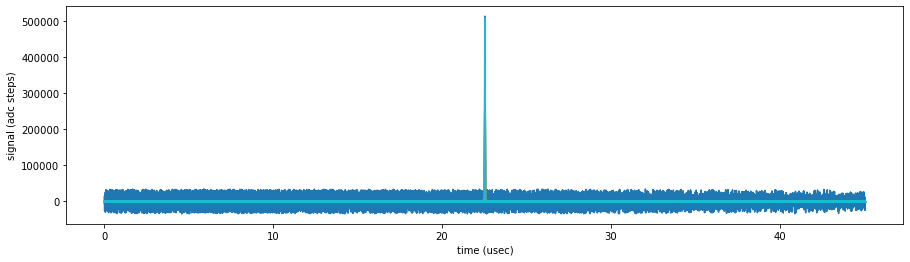

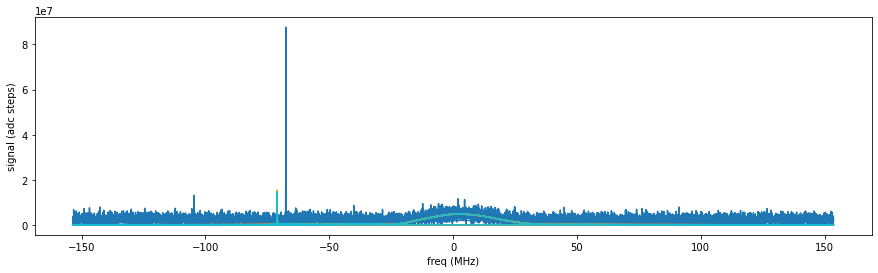

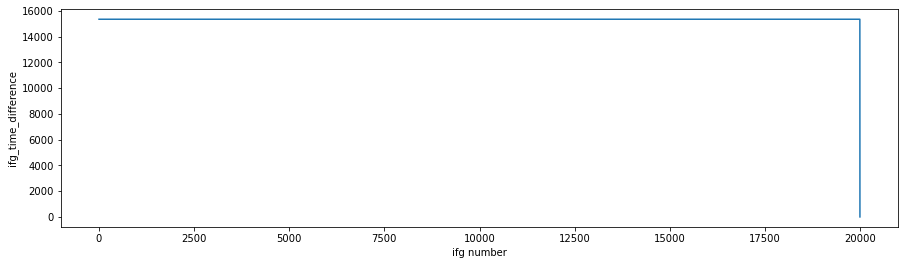

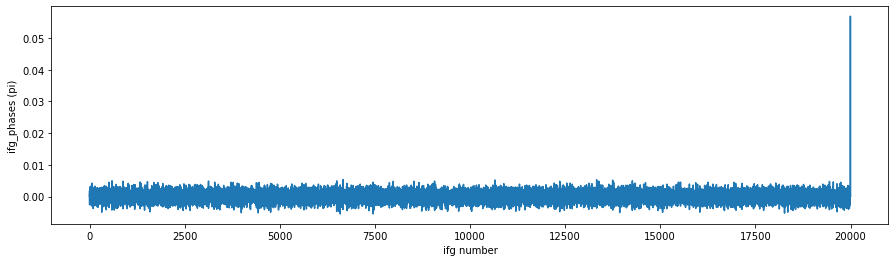

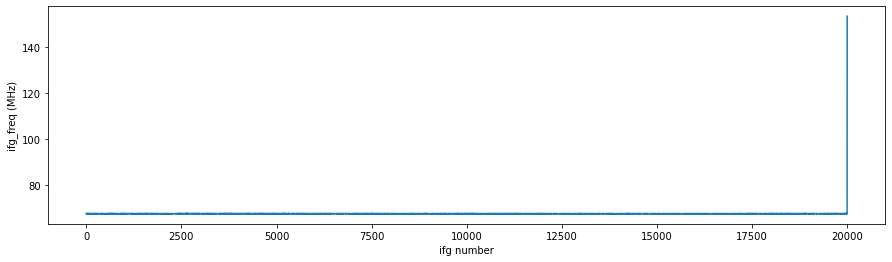

In [19]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_compl.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_compl[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_compl[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([-50, 50])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(delta_times)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_time_difference')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.diff(np.unwrap(phases*np.pi))/np.pi)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_phases (pi)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot((center_freqs*sample_frequency+sample_frequency/2)/1e6)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_freq (MHz)')
plt.show()

In [15]:
# configure to send averages from PL to PS
base.radio.passers_and_dma.output_passer_config_writer_avg.write(base.radio.passers_and_dma.output_passer_config_writer_avg.register_map.send.address, 1)
base.radio.passers_and_dma.output_passer_config_writer_log.write(base.radio.passers_and_dma.output_passer_config_writer_log.register_map.send.address, 1)

# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part which are 32 bit long each but python doesnt know the difference
# the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 2000
data_real = np.zeros([software_traces, int(num_values/2)], dtype=data_type)
data_imag = np.zeros([software_traces, int(num_values/2)], dtype=data_type)

buffer_trig = allocate(shape=(num_values,), dtype=data_type)
buffer_log = allocate(shape=(20000*4,), dtype=np.float32)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)
base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 1)
base.radio.passers_and_dma.axi_dma_log.recvchannel.transfer(buffer_log)

avgs_current = 0
a = time.time()
for idx in np.arange(software_traces):
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
    
    data = np.copy(np.array(buffer_trig))
    data_real[idx, :] = data[::2]
    data_imag[idx, :] = data[1::2]    
    
    avgs_current = avgs_current + hardware_avgs
    if avgs_current>=20000:
        base.radio.passers_and_dma.axi_dma_log.recvchannel.wait()
        # log_data = np.copy(np.array(buffer_log))
        base.radio.passers_and_dma.axi_dma_log.recvchannel.transfer(buffer_log)
        avgs_current = 0
        print('read phase log')
        print(time.time()-a)

base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 0)


RuntimeError: DMA channel not idle

In [ ]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_real.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_real[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_real[idx, :]+1j*data_imag[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()


In [57]:

np.save('data/data_ref_real_' +str(hardware_avgs)+ 'avgs_x200', data_real)
np.save('data/data_ref_imag_' +str(hardware_avgs)+ 'avgs_x200', data_imag)

# np.save('data/data_ref_real_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_real)
# np.save('data/data_ref_imag_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_imag)